### Hot water and steam have been extracted from the Wairakei geothermal system for the last 60 years, used to produce clean, renewable electricity. Unfortunately, as water was extracted, pressure in the reservoir started to rapidly drop. Each year, it became harder and harder to pull more water out.

### In 1965, reservoir engineers realised there was a problem and began a large-scale program of reinjection. The spent geothermal water, once it had been used to generate electicity, was pumped back underground. The result was stabilisation of the reservoir pressure.

### Fortunately, much of this data is avaliable to help us develop a model of the system.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed, interactive_output, HBox, Button, VBox, Output, IntSlider, Checkbox, FloatSlider
TEXTSIZE = 16
from IPython.display import clear_output
import time
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as colmap
from copy import copy


def suspension(t,c,k,m,x0,dxdt0):
	# implements the suspension model (uses complex varaibles but returns real displacements)
	c += 0j
	k += 0j
	rt1,rt2 = -c/(2*m)+np.array([-1.,1.])*np.sqrt(c**2/m**2-4*k/m)
	
	x0 += 0j
	dxdt0 += 0j
	A = (dxdt0 - x0*rt2)/(rt1-rt2)
	B = x0 - A
	
	return np.real(A*np.exp(rt1*t) + B*np.exp(rt2*t))
def get_suspension_data(noisy=False):
	
	# 'true' parameters
	m = 1000.
	c = 24.
	k = 9.
	x0 = 1
	dxdt0 = 0.1
	
	# observation times
	t = np.linspace(0,100,33)
	x = suspension(t,c,k,m,x0,dxdt0)
	
	# add noise if requested
	if noisy:
		# set seed so get same random obs
		np.random.seed(1)
		t1,t2 = [20,60]
		inds = np.where((t>t1)&(t<t2))
		x[inds] = x[inds] + 3.*(np.random.rand(len(inds[0]))-0.5)
	
	return t,x,(m,x0,dxdt0)
# plot data and car suspension model
def plot_suspension_model():
	f = plt.figure(figsize=(12,6))
	ax = plt.axes([0.1,0.1,0.8,0.8])
	
	t,x,pars = get_suspension_data()
	m,x0,dxdt0 = pars
	
	ax.plot(t,np.real(x),'bo',mfc='w',mew=1.5,label='data')
	
	for t in ax.get_xticklabels()+ax.get_yticklabels():
		t.set_fontsize(TEXTSIZE)
		
	ax.set_xlabel('time [s]',size=TEXTSIZE)
	ax.set_ylabel('displacement [m]', size=TEXTSIZE)
	
	np.random.seed(int(time.time()))
	cm = np.random.rand()*100
	km = np.random.rand()*25+2
	t = np.linspace(0,100,201)
	x = suspension(t,cm,km,*pars)
	
	ax.plot(t,x,'k-',mfc='w',mew=1.5,label='model')
	
	ax.legend(loc='lower right', prop={'size':TEXTSIZE})
	ax.set_ylim([-1.5,1.5])
	cm = np.real(cm)
	ax.text(.15, .95, r'$m\ddot{x}+c\dot{x}+kx=0$,   $m=10^3$,   $c='+'{:2.1f}'.format(cm)+'$,   $k='+'{:2.1f}'.format(km)+'$', ha='left', va='top', transform=ax.transAxes, size=20)
	
	plt.show()
def suspension_model():
	rolldice = Button(description='ROLL THE DICE', tooltip='generate a random set of parameters for the model')
	
	out = Output()

	def on_button_clicked(b):
		with out:
			clear_output(True)
			plot_suspension_model()

	rolldice.on_click(on_button_clicked)
	
	with out:
		plot_suspension_model()
	
	#rolldice.on_click(lambda x: plot_suspension_model())
	return VBox([out, rolldice])
	
# plot data, car suspension model, and sum of squares	
def plot_suspension_model2(cm,km,weights=False):
	f = plt.figure(figsize=(12,6))
	ax = plt.axes([0.1,0.1,0.8,0.8])
	
	td,xd,pars = get_suspension_data(noisy=True)
	m,x0,dxdt0 = pars
	
	for t in ax.get_xticklabels()+ax.get_yticklabels():
		t.set_fontsize(TEXTSIZE)
		
	ax.set_xlabel('time [s]',size=TEXTSIZE)
	ax.set_ylabel('displacement [m]', size=TEXTSIZE)
	
	t = np.linspace(0,100,201)
	x = suspension(t,cm,km,*pars)
	xm = suspension(td,cm,km,*pars)
	
	ax.fill_between([20,60],[-1.5,-1.5],[1.5,1.5], color=[0.9,0.9,0.9])
	
	for tdi,xdi,xmi in zip(td,xd,xm):
		if not weights:
			ax.plot([tdi,tdi], [xdi,xmi], 'r-', lw = 2)
		else:
			if 20<tdi<60:
				ax.plot([tdi,tdi], [xdi,xmi], 'r-', lw = 1, alpha=0.5)
			else:
				ax.plot([tdi,tdi], [xdi,xmi], 'r-', lw = 2)
	ax.plot([tdi,tdi], [xdi,xmi], 'r-', lw = 2, label = 'misfit')
	
	ax.plot(td,xd,'bo',mfc='w',mew=1.5,label='data')
	ax.plot(t,x,'k-',mfc='w',mew=1.5,label='model')
	
	ax.legend(loc='lower right', prop={'size':TEXTSIZE})
	ax.set_ylim([-1.5,1.5])
	cm = np.real(cm)
	ax.text(.42, .95, r'malfunctioning recording', ha='center', va='top', transform=ax.transAxes, size=TEXTSIZE)
	ax.arrow(20,1.1, 40,0, head_length=1.5, head_width=0.07, color='k', length_includes_head=True)
	ax.arrow(60,1.1,-40,0, head_length=1.5, head_width=0.07, color='k', length_includes_head=True)
	
	# an array of weights
	sigma = np.ones(len(td))
	if weights:
		t1,t2 = [20,60]
		inds = np.where((td>t1)&(td<t2))
		sigma[inds] = 100.
	sigma /= np.sum(sigma**-2)
	
	#
	#S1 = 1.e32
	#S2 = 1.e32
	#sigma2 = np.ones(len(td))
	#sigma2 /= np.sum(sigma2**-2)
	#for c in range(10,110,10):
	#	for k in range(2,29,2):
	#		S = np.sum(((suspension(td,c,k,*pars)-xd)/sigma)**2)
	#		if S<S1:
	#			save1 = [copy(c),copy(k)]
	#			S1 = copy(S)
	#		S = np.sum(((suspension(td,c,k,*pars)-xd)/sigma2)**2)
	#		if S<S2:
	#			save2 = [copy(c),copy(k)]
	#			S2 = copy(S)
	#print(S1,save1)
	#print(S2,save2)
	
	S = np.sum(((xm-xd)/sigma)**2)
	
	ax.text(.70, .95, r'$S('+'{:d},{:d}'.format(cm,km)+')='+'{:3.2e}'.format(S)+'$', ha='left', va='top', transform=ax.transAxes, size=TEXTSIZE, color = 'r')
	plt.show()
def sum_of_squares():
	
	csldr = IntSlider(value = 50, description='$c$', min=10, max = 100, step=10, continuous_update=False)
	ksldr = IntSlider(value = 13, description='$k$', min=2, max = 27, step=2, continuous_update=False)
	wgts = Checkbox(value = False, description='downweight bad measurements')
	return VBox([HBox([csldr, ksldr, wgts]), interactive_output(plot_suspension_model2, {'cm':csldr,'km':ksldr,'weights':wgts})])	
	
# adhoc calibration exercise
def habanero_eqs(model = None):
	f = plt.figure(figsize=(12,6))
	ax = plt.axes([0.1,0.1,0.8,0.8])
	time,distance = np.genfromtxt('eqs.txt', delimiter = ',', skip_header = 1).T
	ax.plot(time, distance, 'kx', ms = 2)    # plot the analytical solution
	
	if model is not None:
		ax.plot(model[0], model[1], 'b-')
	
	ax.set_xlabel('time [days]', size = TEXTSIZE)
	ax.set_ylabel('distance from well [m]', size = TEXTSIZE)
	ax.set_xlim([10,30])
	ax.set_ylim([0,1650])
	ax.set_title('Earthquake locations during well stimulation', size = TEXTSIZE);
	for tick in ax.get_xticklabels()+ax.get_yticklabels(): tick.set_fontsize(TEXTSIZE)
	plt.show()
# tennis ball example
def vi(h0,g,e,i):  
    # velocity after ith bounce
    return np.sqrt(2*g*h0*e**i)
def u(t,ti,vi,g): 
    # position of bouncing ball
    return -g/2*t**2+(g*ti+vi)*t-vi*ti-g/2*ti**2
def ti1(ti, vi, g):  
    # time between bounces
    return ti+2*vi/g
def tennis_ball_model(g, h0, e):
	# parameters
	Nbounces = 10    # number of bounces to compute
	
	# compute for first "half" bounce
	v0 = vi(h0,g,e,0)
	t0 = -v0/g
	tv = np.linspace(0, -t0, 101)   # time vector
	uv = u(tv,t0,v0,g)              # position vector
	ti = ti1(t0,v0,g)               # update bounce time

    # loop through number of bounces
	for i in range(1,Nbounces+1):
		vv = vi(h0,g,e,i)               # velocity at start of bounce
		ti = ti1(ti,vv,g)               # update bounce-time
		tnew = np.linspace(tv[-1], ti, 101)   # time vector for bounce
		unew = u(tnew,tv[-1],vv,g)      # position during bounce
		tv = np.concatenate((tv,tnew))  # update full time vector
		uv = np.concatenate((uv,unew))  # update full position vector
		
	return tv, uv
def tennis_ball_plot(model = None, data=None, threshold = None, tmax = 12, umax=10):
	f = plt.figure(figsize=(12,6))
	ax = plt.axes([0.1,0.1,0.8,0.8])
	
	if data is not None:
		ax.plot(data[0], data[1], 'ro')    # plot the analytical solution
	
	if model is not None:
		tm, um = tennis_ball_model(model[0], model[1], model[2])
		ax.plot(tm, um, 'b-')
		
	if model is not None and data is not None:
		udi = np.interp(data[0],tm,um)
		S = np.sum((udi-data[1])**2)
		ax.text(0.95, 0.95, 'objective function = %2.1f'%S, transform=ax.transAxes, ha = 'right', va = 'top', size = 20)
		
	if threshold is not None:
		ax.axhline(threshold, color='k', linestyle='--')
	
	ax.set_xlabel('time', size = TEXTSIZE)
	ax.set_ylabel('height [m]', size = TEXTSIZE)
	ax.set_xlim([0,tmax]); ax.set_ylim([0,umax])
	for tick in ax.get_xticklabels()+ax.get_yticklabels(): tick.set_fontsize(TEXTSIZE)
	plt.show()
# parameter space figures
def r(X,Y,p): 
	return (p[0]-np.exp(-((X-p[3])**2/p[5]+(Y-p[4])**2/p[6])))*(1-(X/p[1])**p[2])*(1+(Y/p[1])**p[2])
def plot_parameter_space(ic,ik):
	x = np.linspace(0,1,31)
	y = np.linspace(0,1,31)

	xm = np.mean(x)*0.8
	ym = np.mean(y)*1.2
	sx = 0.02*3.
	sy = 0.04*3.

	ymin,ymax = [0.15,0.85]
	i1 = np.argmin(abs(y-ymin))
	i2 = np.argmin(abs(y-ymax))
	y2 = y[i1:i2+1]

	[X,Y] = np.meshgrid(x,y)
	[X2,Y2] = np.meshgrid(x,y2)
	
	fig = plt.figure(figsize=[8,8])
	ax = fig.add_subplot(111, projection='3d')
	ax.plot3D([0,1],[y[i1], y[i1]],[7,7], 'k:', lw = 1, zorder = 1)
	ax.plot3D([0.72,1],[y[i2], y[i2]],[7,7], 'k:', lw = 1, zorder = 1)
	
	n = 2
	a = 4
	obs = 10.
	p = [obs, a, n, xm, ym, sx, sy]
	
	xi = x[ic]
	yi = y[ik]
	zi = r(xi,yi,p)
	
	ax.plot3D([xi,xi,xi,xi,x[-1]],[yi,yi,y[0],yi,yi],[zi,7,7,7,7],'k-', ms = 10, mew=2, zorder=2)
	
	ax.plot3D([xi,],[yi,],[7,],'ks', ms = 8, mfc='w', mew=2, zorder=2)
	ax.text3D(xi,yi,7.3,'\n'+r'$\theta$', va= 'top',ha='center',size=TEXTSIZE)
	
	ax.plot_wireframe(X, Y, r(X,Y,p), lw = 0.5, color = 'k', zorder=4)
	ax.plot_surface(X2, Y2, r(X2,Y2,p), rstride=1, cstride=1,cmap=colmap.Oranges, lw = 0.5, zorder=3)
	
	ax.plot3D([xi,],[yi,],[zi,],'kx', ms = 10, mew=2,zorder=5)
	ax.text3D(xi,yi,zi+0.3,r'$S(\theta)$', va= 'bottom',ha='center',size=TEXTSIZE, backgroundcolor='w', bbox={'pad':0.1,'color':'w'})
			
	ax.set_zlim([7,13])
	ax.set_xlim([0,1])
	ax.set_ylim([0,1])

	ax.set_xticklabels([])
	ax.set_yticklabels([])
	ax.set_zticklabels([])

	ax.set_xlabel('$c$', size=TEXTSIZE)
	ax.set_ylabel('$k$', size=TEXTSIZE)
	ax.set_zlabel(r'$S(\mathbf{\theta})$', rotation = 180., size=TEXTSIZE)
	
	plt.show()
	
def parameter_space():	
	csldr = IntSlider(value = 10, description='$c$', min=0, max = 31, step=1, readout=False, continuous_update=False)
	ksldr = IntSlider(value = 10, description='$k$', min=4, max = 25, step=1, readout=False, continuous_update=False)
	return VBox([HBox([csldr, ksldr]), interactive_output(plot_parameter_space, {'ic':csldr,'ik':ksldr})])
	
def plot_parameter_space2(ic,ik,check):
	fig = plt.figure(figsize=[8,8])
	ax = plt.axes([0.1,0.1,0.8,0.8])
	x = np.linspace(0,1,101)
	y = np.linspace(0,1,101)

	xm = np.mean(x)*0.8
	ym = np.mean(y)*1.2
	sx = 0.02*3.
	sy = 0.04*3.

	ymin,ymax = [0.15,0.85]
	i1 = np.argmin(abs(y-ymin))
	i2 = np.argmin(abs(y-ymax))
	y2 = y[i1:i2+1]

	[X,Y] = np.meshgrid(x,y)
	[X2,Y2] = np.meshgrid(x,y2)
	
	n = 2
	a = 4
	obs = 10.
	p = [obs, a, n, xm, ym, sx, sy]

	xi = ic/20*x[-1]+x[0]
	yi = ik/20*y[-1]+y[0]
	zi = r(xi,yi,p)
	if check:
		xi1 = (ic+1)/20*x[-1]+x[0]
		dxi1 = 1/20*x[-1]
		yi1 = (ik+1)/20*y[-1]+y[0]
		dyi1 = 1/20*y[-1]*2.
		zi01 = r(xi1,yi,p)
		zi10 = r(xi,yi1,p)
		s = np.array([(zi01-zi)/dxi1, (zi10-zi)/dyi1])
		s = -s/np.sqrt(np.dot(s,s))
	
	
	ax.set_xticks([xi,])
	ax.set_yticks([yi,])
	ax.set_yticklabels(['{:2.1f}'.format(yi*2.)])
	ax.set_xlabel('c', size=TEXTSIZE)
	ax.set_ylabel('k', size=TEXTSIZE)
	if check:
		ax.arrow(xi,yi,s[0]/20., s[1]/20., head_length = 0.015, head_width=0.015, color = 'k')
		ax.plot([x[0], xi, xi],[yi,yi,y[0]],'k:', lw=0.5, zorder=3)
	else:
		ax.plot([x[0], xi, xi],[yi,yi,y[0]],'k-',zorder=3)
	ax.plot(xi,yi,'kx',zorder=3, ms=10, mew=2)
	
	for t in ax.get_xticklabels()+ax.get_yticklabels(): t.set_fontsize(TEXTSIZE)
		
	levels = np.linspace(np.min(r(X,Y,p)), np.max(r(X,Y,p)), 11)
	ax.contourf(X2,Y2,r(X2,Y2,p), cmap = colmap.Oranges, levels = levels)
	ax.contour(X,Y,r(X,Y,p), levels = levels, colors = 'k', linewidths = 1)
	
	if check:
		txt = r'-$\hat{\mathbf{s}}$='+'[{:0.2f},{:0.2f}]'.format(s[0],s[1])
	else:
		txt = '$S$={:4.3f}'.format(zi)
	ax.text(0.05,0.95,txt, ha='left', va='top', transform=ax.transAxes, size=20, backgroundcolor='w')
	plt.show()
	
def sensitivity():
	csldr = IntSlider(value = 10, description='$c$', min=0, max = 20, step=1, readout=False, continuous_update=False)
	ksldr = IntSlider(value = 10, description='$k$', min=3, max = 17, step=1, readout=False, continuous_update=False)
	check = Checkbox(value = False, description='check my answer')
	return VBox([HBox([csldr, ksldr, check]), interactive_output(plot_parameter_space2, {'ic':csldr,'ik':ksldr, 'check':check})])

def plot_parameter_space3(ic,ik,N=0,alpha=0.03):
	fig = plt.figure(figsize=[8,8])
	ax = plt.axes([0.1,0.1,0.8,0.8])
	x = np.linspace(0,1,101)
	y = np.linspace(0,1,101)

	xm = np.mean(x)*0.8
	ym = np.mean(y)*1.2
	sx = 0.02*3.
	sy = 0.04*3.

	ymin,ymax = [0.15,0.85]
	i1 = np.argmin(abs(y-ymin))
	i2 = np.argmin(abs(y-ymax))
	y2 = y[i1:i2+1]

	[X,Y] = np.meshgrid(x,y)
	[X2,Y2] = np.meshgrid(x,y2)
	
	n = 2
	a = 4
	obs = 10.
	p = [obs, a, n, xm, ym, sx, sy]

	xi = ic/20*x[-1]+x[0]
	yi = ik/20*y[-1]+y[0]
	ax.plot([x[0], xi, xi],[yi,yi,y[0]],'k:', lw=0.5, zorder=3)
	ax.set_xticks([xi,])
	ax.set_yticks([yi,])
	ax.set_yticklabels(['{:2.1f}'.format(yi*2.)])
	
	x = [xi,]
	y = [yi,]
	ax.plot(xi,yi,'kx',lw=2, ms=10, mew=2)
	
	for i in range(N):
		dx = 0.01
		zi = r(xi,yi,p)
		s = np.array([(r(xi+dx,yi,p)-zi)/dx,(r(xi,yi+dx,p)-zi)/dx])
		s = -s/np.sqrt(np.dot(s,s))
		
		xi1,yi1 = np.array([xi,yi]) + alpha*s
		
		ax.arrow(xi,yi,xi1-xi,yi1-yi,color='k',head_length = 0.015, head_width=0.015, length_includes_head=True)
		
		xi = 1.*xi1
		yi = 1.*yi1
	
	for t in ax.get_xticklabels()+ax.get_yticklabels(): t.set_fontsize(TEXTSIZE)
		
	ax.set_xlabel('c', size=TEXTSIZE)
	ax.set_ylabel('k', size=TEXTSIZE)
	
	levels = np.linspace(np.min(r(X,Y,p)), np.max(r(X,Y,p)), 11)
	ax.contourf(X2,Y2,r(X2,Y2,p), cmap = colmap.Oranges, levels = levels)
	ax.contour(X,Y,r(X,Y,p), levels = levels, colors = 'k', linewidths = 1)
	
	plt.show()
		
def gradient_descent():
	csldr = IntSlider(value = 10, description='$c$', min=0, max = 20, step=1, readout=False, continuous_update=False)
	ksldr = IntSlider(value = 10, description='$k$', min=3, max = 17, step=1, readout=False, continuous_update=False)
	Nsldr = IntSlider(value = 0, description='steps', min=0, max = 10, step=1, continuous_update=False)
	asldr = FloatSlider(value = 0.05, description=r'$\alpha$', min=0, max = 0.10, step=0.02, continuous_update=False)
	return VBox([HBox([csldr, ksldr, Nsldr, asldr]), interactive_output(plot_parameter_space3, {'ic':csldr,'ik':ksldr, 'N':Nsldr, 'alpha':asldr})])
	
	
	
	
	
	
	
	

In [3]:
suspension_model()

In [4]:
sum_of_squares()

In [5]:
import sympy as sp
r,t,A,B,D = sp.symbols('r,t,A,B,D')

In [6]:
p = A + B*sp.Ei(-r**2/(4*D*t))
print('p =',p)



p = A + B*Ei(-r**2/(4*D*t))


In [7]:
dpdr = sp.diff(p,r,1)      # 1st deriv. of p wrt. r
d2pdr2 = sp.diff(p,r,2)    # 2nd deriv. of p wrt. r
dpdt = sp.diff(p,t,1)      # 1st deriv. of p wrt. t
print('dpdr =',dpdr)
print('d2pdr2 =',d2pdr2)
print('dpdt =',dpdt)

dpdr = 2*B*exp(-r**2/(4*D*t))/r
d2pdr2 = -B*(2/r**2 + 1/(D*t))*exp(-r**2/(4*D*t))
dpdt = -B*exp(-r**2/(4*D*t))/t


In [8]:
bal = d2pdr2 + dpdr/r - dpdt/D
print('bal =',bal)

bal = -B*(2/r**2 + 1/(D*t))*exp(-r**2/(4*D*t)) + 2*B*exp(-r**2/(4*D*t))/r**2 + B*exp(-r**2/(4*D*t))/(D*t)


In [9]:
expanded_bal = bal.expand()
print('expanded_bal =',expanded_bal)


expanded_bal = 0


In [10]:
from ipywidgets import interact
import numpy as np

def diffusion_model(t,D,t0):
    # implement a simple diffusion model, including a time offset
    # note, D here is the effective Diffusivity
    return np.array([np.sqrt(D*(ti-t0)) if ti>t0 else 0. for ti in t])

def fit_model(logD, t0):
    tv = np.linspace(10,30,100)          # time vector to solve the model
    rv = diffusion_model(tv, 10**logD, t0)
    habanero_eqs([tv,rv])
    
interact(fit_model, logD = (2,8,0.5), t0 = (10,20,1))

interactive(children=(FloatSlider(value=5.0, description='logD', max=8.0, min=2.0, step=0.5), IntSlider(value=…

<function __main__.fit_model(logD, t0)>

In [11]:
import numpy as np
from matplotlib import pyplot as plt

# parameters
Nbounces = 5    # number of bounces to compute
h0 = 10.0       # initial height dropped from
g = 9.81        # gravity

# functions
def vi(h0,g,e,i):  
    # velocity after ith bounce
    return np.sqrt(2*g*h0*e**i)
def u(t,ti,vi,g): 
    # position of bouncing ball
    return -g/2*t**2+(g*ti+vi)*t-vi*ti-g/2*ti**2
def ti1(ti, vi, g):  
    # time between bounces
    return ti+2*vi/g

def plot_bounces(e):
    # compute for first "half" bounce
    v0 = vi(h0,g,e,0)
    t0 = -v0/g
    tv = np.linspace(0, -t0, 101)   # time vector
    uv = u(tv,t0,v0,g)              # position vector
    ti = ti1(t0,v0,g)               # update bounce time

    # loop through number of bounces
    for i in range(1,Nbounces+1):
        vv = vi(h0,g,e,i)               # velocity at start of bounce
        ti = ti1(ti,vv,g)               # update bounce-time
        tnew = np.linspace(tv[-1], ti, 101)   # time vector for bounce
        unew = u(tnew,tv[-1],vv,g)      # position during bounce
        tv = np.concatenate((tv,tnew))  # update full time vector
        uv = np.concatenate((uv,unew))  # update full position vector
    
    # plot the solution
    f,ax = plt.subplots(1,1,figsize=(12,6))
    ax.plot(tv,uv,'b-')
    ax.set_xlabel('t'); ax.set_ylabel('u')
    ax.set_xlim([0,10])

# interactive model output
interact(plot_bounces, e = (0., 1., 0.1))

interactive(children=(FloatSlider(value=0.5, description='e', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.plot_bounces(e)>

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from ipywidgets import interact, fixed, interactive_output, HBox, Button, VBox, Output, IntSlider, Checkbox, FloatSlider, FloatLogSlider, Dropdown
TEXTSIZE = 16
from IPython.display import clear_output
import time
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as colmap
from copy import copy
from scipy.stats import multivariate_normal

# general figures
def plot_priors(thmin, thmax, thmean, thstd):
	f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
	ax1.set_ylim([0,10])
	x = np.linspace(-0.01,1.01,1001)
	ymax = 1./(thmax-thmin)
	y = ymax + 0.*x
	y[np.where((x<thmin)|(x>thmax))] = 0.
	ax1.plot(x,y,'k-')
	ax1.set_xticks([thmin,thmax])
	ax1.set_xticklabels([r'$\theta_{min}$',r'$\theta_{max}$'])
	ax1.set_yticks([ymax])
	ax1.set_yticklabels([r'$(\theta_{max}-\theta_{min})^{-1}$'])
	ax1.set_xlim([-0.05,1.05])
		
	y = np.exp(-(x-thmean)**2/(2*thstd**2))/np.sqrt(2*np.pi*thstd**2)
	ax2.set_xlim([0.2,0.8])
	ax2.set_ylim([0,15])
	ax2.plot(x,y,'k-')
	ax2.set_xticks([thmean])
	ax2.set_xticklabels([r'$\bar{\theta}$'])
	ax2.set_yticks([1./np.sqrt(2*np.pi*thstd**2)])
	ax2.set_yticklabels([r'$(2\pi\sigma_\theta^2)^{-1/2}$'])
		
	plt.show()
def priors():
	thmin = FloatSlider(value=0.099, description=r'$\theta_{min}$', min = -0.001, max = 0.499, step = 0.1, continuous_update = False, readout=False)
	thmax = FloatSlider(value=0.901, description=r'$\theta_{max}$', min = 0.501, max = 1.001, step = 0.1, continuous_update = False, readout=False)
	thmean = FloatSlider(value=0.5, description=r'$\bar{\theta}$', min = 0.3, max = 0.7, step = 0.1, continuous_update = False, readout=False)
	thstd = FloatSlider(value=0.05, description=r'$\sigma_\theta$', min = 0.03, max = 0.07, step = 0.02, continuous_update = False, readout=False)
	io = interactive_output(plot_priors, {'thmin':thmin,'thmax':thmax,'thmean':thmean,'thstd':thstd})
	return VBox([HBox([thmin,thmean]), HBox([thmax,thstd]), io])

# linear model
def f(x,m,c): 
    return m*x+c
def err(x,var): 
    return np.random.randn(len(x))*np.sqrt(var)
def plot_observations(N_obs, bestModel, trueModel, var, seed):#, true_model, RMS_fit, error_dist):
	# define a model
	x = np.linspace(0,1,101)

	# model parameters
	m0 = 2.       # true gradient
	c0 = 3.       # true intercept
	
	# compute the "true" model, using the "true" parameters
	y = f(x,m0,c0)

	# seed the random number generator so we get the same numbers each time
	np.random.seed(seed)
	
	# define some values of the independent variable at which we will be taking our "observations"
	xo = np.linspace(0,1,12)[1:-1]

	# compute the observations - "true" model + random error (drawn from normal distribution)
	yo = f(xo,m0,c0) + err(xo,var)

	# initialize figure window and axes
	fig,ax = plt.subplots(1,1,figsize=(12,6))
	
	# plot the observations
	i = np.min([len(xo), N_obs])
	ln2 = ax.plot(xo[:i],yo[:i],'wo', mec = 'k', mew = 1.5, ms = 5, label = r'observations', zorder = 10)
	
	# add "best-fit" model if appropriate
	if bestModel:
		# find best-fit model
		p2,pc = curve_fit(f, xo[:i], yo[:i], [1,1])
		# plot model
		ax.plot(x,f(x,*p2),'r-', label = 'best model')
	
	# plot the "true" model    
	if trueModel:
		ln1 = ax.plot(x,y,'b-', label = 'true process',zorder = 10)
	
	# add normal distributions to plot
	yvar = 15.*np.sqrt(var)
	ye = np.linspace(-yvar,yvar,101)*0.2
	ye2 = np.linspace(-yvar,yvar,101)*0.25
	# loop over observations
	for xoi, yoi in zip(xo[:i],yo[:i]):
		# normal dist
		xi = 0.05*np.exp(-(ye)**2/var)+xoi
		# add to plot
		ax.plot(xi, ye+f(xoi,m0,c0), 'k-', lw = 0.5, zorder = 0)
		ax.plot(xi*.0+xoi, ye2+f(xoi,m0,c0), '-', lw = 0.5, zorder = 0, color = [0.5, 0.5, 0.5])

	# plot upkeep + legend
	ax.set_xlim(ax.get_xlim())
	ax.legend(loc=2, prop={'size':TEXTSIZE})
	ax.set_ylim([1,7])
	ax.set_xlim([0,1])
	ax.set_xlabel('$x$',size = TEXTSIZE)
	ax.set_ylabel('$y$',size = TEXTSIZE)
	for t in ax.get_xticklabels()+ax.get_yticklabels(): t.set_fontsize(TEXTSIZE)
def observation_error():
	#out = Output()
	seed = 13
	rolldice = Button(description='ROLL THE DICE', tooltip='randomise the random number generator')
	Nsldr = IntSlider(value=5, description='$N_{obs}$', min = 2, max = 10, step = 1, continuous_update = False)
	trueModel = Checkbox(value = False, description='True Process')
	bestModel = Checkbox(value = False, description='Best (LSQ) Model')
	varsldr = FloatLogSlider(value=0.1, base=10, description='$\sigma_i^2$', min = -2, max = 0, step = 1, continuous_update = False)
	sdf = fixed(seed)
	
	np.random.seed(13)
	def on_button_clicked(b):
		sdf.value = int(time.time())		
		
	rolldice.on_click(on_button_clicked)
	io = interactive_output(plot_observations, {'N_obs':Nsldr,'trueModel':trueModel,'bestModel':bestModel,'var':varsldr,'seed':sdf})
	
	return VBox([HBox([Nsldr, bestModel, trueModel, rolldice, varsldr]), io])
def get_obs(seed, Nobs, mtrue, ctrue,var):
	np.random.seed(seed)
	xo = np.linspace(0,1,Nobs+2)[1:-1]
	yo = f(xo,mtrue,ctrue) + err(xo,var)
	return xo,yo
def plot_posterior(m,c,p):
	x = np.linspace(0,1,101)
	m0,c0 = [2,3]
	var = 0.1
	y = f(x,m0,c0)
	xo,yo = get_obs(13,10,m0,c0,var)
	mf,cf = curve_fit(f, xo, yo, [1,1])[0]

	# initialize figure window and axes
	fig = plt.figure(figsize=(12,6))
	ax1 = plt.axes([0.05, 0.15, 0.35, 0.7])
	ax2 = plt.axes([0.55, 0.15, 0.35, 0.7])
	ax3 = plt.axes([0.95, 0.15, 0.02, 0.7])
	ax4 = fig.add_subplot(122, projection='3d')
	dx = 0.15; dy = 0.25
	ax4.set_position([0.555,0.155,dx,dy])
	ax4.set_xticks([])
	ax4.set_yticks([])
	ax4.set_zticks([])
	ax4.set_facecolor(cm.jet(0))
	#fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
	ax1.plot(xo,yo,'wo', mec = 'k', mew = 1.5, ms = 8, label = r'observations', zorder = 10)
	ax1.plot(x,f(x,mf,cf),'r-', label = 'best model')
	ax1.plot(x,y,'b-',label='true process')
	ax1.plot(x,f(x,m,c),'g-')
	
	# show 
	CS = ax2.imshow(np.flipud(p.P), cmap=cm.jet, extent = [p.mmin,p.mmax,p.cmin,p.cmax], aspect='auto')
	plt.colorbar(CS, cax = ax3)
	ax2.plot(m0,c0,'bo', label=r'$\theta_0$',ms = 12, mec='w', mew=3)
	ax2.plot(mf,cf,'ro', label=r'$\hat{\theta}_0$',ms = 12, mec='w', mew=3)
	ax2.plot(m, c, 'go', label=r'$\theta$',ms = 12, mec='w', mew=3)
	ax2.legend(loc=1, prop={'size':TEXTSIZE})
	ax4.plot_surface(p.M, p.C, p.P, rstride=1, cstride=1, cmap=cm.jet, lw = 0.5, zorder = 10)
	
	# plot upkeep + legend
	ax1.set_xlim(ax1.get_xlim())
	ax1.legend(loc=2, prop={'size':TEXTSIZE})
	ax1.set_ylim([1,7])
	ax1.set_xlim([0,1])
	ax1.set_xlabel('$x$',size = TEXTSIZE)
	ax1.set_ylabel('$y$',size = TEXTSIZE)
	ax2.set_xlabel('$m$',size = TEXTSIZE)
	ax2.set_ylabel('$c$',size = TEXTSIZE)
	ax3.set_xlabel('\n'+r'$P(\theta)$',size=TEXTSIZE,rotation=0.)
	for ax in [ax1,ax2,ax3]:
		for t in ax.get_xticklabels()+ax.get_yticklabels(): 
			t.set_fontsize(TEXTSIZE)
def posterior(Nm, Nc):
	mtrue,ctrue = [2,3]
	cmin,c0,cmax = [2.55,3.05,3.55]
	mmin,m0,mmax = [1.3,2.1,2.9]
	m = FloatSlider(value=m0, description=r'$m$', min = mmin, max = mmax, step = (mmax-mmin)/Nm, continuous_update = False)
	c = FloatSlider(value=c0, description=r'$c$', min = cmin, max = cmax, step = (cmax-cmin)/Nc, continuous_update = False)
	p = Posterior(cmin=cmin,cmax=cmax,Nc=Nc,mmin=mmin,mmax=mmax,Nm=Nm,ctrue=ctrue,mtrue=mtrue,var=0.1)
	io = interactive_output(plot_posterior, {'m':m,'c':c,'p':fixed(p)})
	return VBox([HBox([m,c]),io])
class Posterior(object):
	def __init__(self,**kwargs):
		for k in kwargs.keys():
			self.__setattr__(k, kwargs[k])
		self.grid_search()
		self.fit_mvg()
	def grid_search(self):
		xo,yo = get_obs(13,10,self.mtrue,self.ctrue,self.var)
		m = np.linspace(self.mmin,self.mmax,self.Nm); dm = m[1]-m[0]
		c = np.linspace(self.cmin,self.cmax,self.Nc); dc = c[1]-c[0]
		self.dm = dm
		self.dc = dc
		M,C = np.meshgrid(m,c)
		# compute objective function
			# empty vector, correct size, for storing computed objective function
		S = 0.*M.flatten() 
			# for each parameter combination in the grid search
		for i,theta in enumerate(zip(M.flatten(), C.flatten())):
				# unpack parameter vector
			mi,ci = theta
				# compute objective function
			S[i]=np.sum((yo-f(xo,mi,ci))**2)/self.var
			# reshape objective function to meshgrid dimensions
		S = np.array(S).reshape([len(c), len(m)])
			# compute posterior
		self.P = np.exp(-S/2.)
		self.P /= np.sum(self.P)*dm*dc
		self.M = M
		self.C = C
	def fit_mvg(self):
		mv, cv, pv = [vi.flatten() for vi in [self.M,self.C,self.P]]
		self.m1 = np.sum(pv*mv)*self.dm*self.dc
		self.c1 = np.sum(pv*cv)*self.dm*self.dc
			# variances
		smm = np.sum(pv*(mv-self.m1)**2)*self.dm*self.dc
		scc = np.sum(pv*(cv-self.c1)**2)*self.dm*self.dc
		scm = np.sum(pv*(mv-self.m1)*(cv-self.c1))*self.dm*self.dc
			# matrix
		self.cov = np.array([[smm,scm],[scm,scc]])
class UberPosterior(object):
	def __init__(self, **kwargs):
		for k in kwargs.keys():
			self.__setattr__(k, kwargs[k])
		self.xo,self.yo = get_obs(13,10,2,3,self.var)
		for model in ['linear','log','power','sin']:
			self.fit(model)
	def fit(self, model):
		if model is 'linear':
			self.f = linear
			self.Nargs = 2
		elif model is 'power':
			self.f = powerlaw
			self.Nargs = 3
		elif model is 'log':
			self.f = logarithmic
			self.Nargs = 3
		elif model is 'sin':
			self.f = sinusoid
			self.Nargs = 3
		self.grid_search()
		self.__setattr__(model+'_mean', self.mean)
		self.__setattr__(model+'_cov', self.cov)
		self.__setattr__(model, self.f)
		self.__setattr__(model+'_P', self.P)
		self.__setattr__(model+'_PVS', self.PVS)
		self.__setattr__(model+'_dps', self.dps)
	def grid_search(self):
		# get best fit parameters for model
		pi = np.ones(self.Nargs)
		if self.f is sinusoid:	
			pi = [3, 2, 3]
		p,pcov = curve_fit(self.f, self.xo, self.yo, pi, sigma=np.sqrt(self.var/2.)+0.*self.xo, absolute_sigma=True)
		self.mean = p
		self.cov = pcov
		# setup search grid
		pvs = []
		self.dps = []
		for i,pi in enumerate(p):
			pvs.append(np.linspace(pi/3.,pi*3., self.N))
			self.dps.append(abs(pvs[-1][1]-pvs[-1][0]))
		self.PVS = np.meshgrid(*pvs)
		
		# compute objective function
			# empty vector, correct size, for storing computed objective function
		S = 0.*self.PVS[0].flatten() 
			# for each parameter combination in the grid search
		for i,theta in enumerate(zip(*[PVSI.flatten() for PVSI in self.PVS])):
			# compute objective function
			S[i]=np.sum((self.yo-self.f(self.xo,*theta))**2)/self.var
			# reshape objective function to meshgrid dimensions
		S = np.array(S).reshape([len(pv) for pv in pvs])
			# compute posterior
		self.P = np.exp(-S/2.)
		self.P /= np.sum(self.P)*np.product(self.dps)
	def get_samples(self,option,N):
		# use rejection sampling on the posterior
		s = []
		P = self.__getattribute__(option+'_P')
		PVS = self.__getattribute__(option+'_PVS')
		dps = self.__getattribute__(option+'_dps')
		pmax = np.max(P)
		inds = np.where(P>pmax/1000.)
		P2 = P[inds]
		PVS2 = [pvsi[inds] for pvsi in PVS]
		N2 = len(P2)
		while len(s) < N:
			i = np.random.randint(0, N2)
			r = np.random.rand()*pmax
			if P2[i] > r:
				s.append([pvsi[i]+dpsi*(np.random.rand()-0.5) for pvsi,dpsi in zip(PVS2,dps)])
		return s
def plot_predictions(zoom, N, xf, p):
	fig = plt.figure(figsize=(15,5))
	ax1 = plt.axes([0.05, 0.15, 0.25, 0.7])
	ax2 = plt.axes([0.37, 0.15, 0.25, 0.7])
	ax3 = plt.axes([0.69, 0.15, 0.25, 0.7])
	
	x = np.linspace(0,5.5,101)
	m0,c0 = [2,3]
	xo,yo = get_obs(13,10,m0,c0,p.var)
	mf,cf = curve_fit(f, xo, yo, [1,1])[0]

	# get samples
	np.random.seed(13)
	s = multivariate_normal.rvs(mean = [p.m1, p.c1], cov = p.cov, size = int(N))
	if N == 1: 
		s = [s,]
	
	ax1.plot(xo,yo,'wo', mec = 'k', mew = 1.5, ms = 8, label = r'obs.', zorder = 10)
	ax1.plot(x,f(x,mf,cf),'r-', label = 'best model',zorder = 1)
	ax1.plot(x,f(x,m0,c0),'b-',label='true process',zorder = 1)
	
	CS = ax2.imshow(np.flipud(p.P), cmap=cm.jet, extent = [p.mmin,p.mmax,p.cmin,p.cmax], aspect='auto')
	ax2.plot(m0,c0,'bo', label=r'$\theta_0$',ms = 12, mec='w', mew=3, zorder=3)
	ax2.plot(mf,cf,'ro', label=r'$\hat{\theta}_0$',ms = 12, mec='w', mew=3, zorder = 3)
	xlim = ax2.get_xlim(); ax2.set_xlim(xlim)
	ylim = ax2.get_ylim(); ax2.set_ylim(ylim)
	
	alpha = np.min([0.5,10./N])
	yfs = []
	for i,si in enumerate(s):
		ax1.plot(x,f(x,*si),'k-', zorder = 0, lw = 0.5, alpha = alpha)
		ax2.plot(*si, 'kx', mew = 2, ms = 8)
		yfs.append(f(xf,*si))
	ax2.plot([],[], 'kx', mew = 2, ms = 8, label = 'sample')
	ax1.plot([],[],'k-', zorder = 0, lw = 0.5, label='sample')
	
	bins = np.linspace(np.min(yfs)*0.999, np.max(yfs)*1.001, int(np.sqrt(N))+1)
	h,e = np.histogram(yfs, bins)
	h = h/(np.sum(h)*(e[1]-e[0]))
	ax3.bar(e[:-1],h,e[1]-e[0], color = [0.5,0.5,0.5])
	ax3.set_xlim([4,20])
	ax3.set_ylim([0,1])
	
	if N>10:
		yf = f(xf, mf, cf)
		ax3.axvline(yf, label='best model',color = 'r', linestyle = '-')
		y0 = f(xf, m0, c0)
		ax3.axvline(y0, label='true process',color = 'b', linestyle = '-')
		
		yf5,yf95 = np.percentile(yfs, [5,95])
		ax3.axvline(yf5, label='90% interval',color = 'k', linestyle = '--')
		ax3.axvline(yf95, color = 'k', linestyle = '--')
		
	
	ax1.set_xlim(ax1.get_xlim())
	ax1.axvline(xf, color = 'k', linestyle=':', label = '$x_f$')
	ax1.legend(loc=4, prop={'size':TEXTSIZE-1})
	ax2.legend(loc=3, prop={'size':TEXTSIZE})
	ax3.legend(loc=1, prop={'size':TEXTSIZE})
	ax1.set_ylim([0,15])
	ax1.set_xlim([0,5.5])
	if zoom:
		ax1.set_ylim([1,7])
		ax1.set_xlim([0,1])
	ax1.set_xlabel('$x$',size = TEXTSIZE)
	ax1.set_ylabel('$y$',size = TEXTSIZE)
	ax2.set_xlabel('$m$',size = TEXTSIZE)
	ax2.set_ylabel('$c$',size = TEXTSIZE)
	ax3.set_xlabel('$y_f$',size = TEXTSIZE)
	ax3.set_ylabel('$P(y_f)$',size = TEXTSIZE)
		
	for ax in [ax1,ax2,ax3]:
		for t in ax.get_xticklabels()+ax.get_yticklabels(): 
			t.set_fontsize(TEXTSIZE)
def prediction(var):
	mtrue,ctrue = [2,3]
	cmin,c0,cmax = [2.55,3.05,3.55]
	mmin,m0,mmax = [1.3,2.1,2.9]
	cmin,c0,cmax = [1.55,3.05,4.55]
	mmin,m0,mmax = [0.3,2.1,4.9]
	p = Posterior(cmin=cmin,cmax=cmax,Nc=101,mmin=mmin,mmax=mmax,Nm=101,ctrue=ctrue,mtrue=mtrue,var=var)
	zoom = Checkbox(value = False, description='zoom')
	Nsamples = FloatLogSlider(value = 16, base=4, description='samples', min = 0, max = 5, step = 1, continuous_update=False)
	xf = FloatSlider(value=3, description=r'$x_f$', min = 2, max = 5, step = 0.5, continuous_update = False)
	io = interactive_output(plot_predictions, {'zoom':zoom,'N':Nsamples,'xf':xf,'p':fixed(p)})
	return VBox([HBox([zoom,Nsamples,xf]),io])
def linear(x, *p): return p[0]*x + p[1]
def logarithmic(x, *p): return p[0]+p[1]*np.log10(x+p[2])
def powerlaw(x, *p): return p[0]+p[1]*x**p[2]
def sinusoid(x, *p): return p[0]+p[1]*np.sin(p[2]*(x-0.1))
def plot_structural(zoom, option, xf, p):
	fig = plt.figure(figsize=(12,6))
	ax1 = plt.axes([0.05, 0.15, 0.35, 0.7])
	ax2 = plt.axes([0.55, 0.15, 0.35, 0.7])
	
	if option == 1:
		f2 = powerlaw
		col = 'm'
		option = 'power'
	elif option == 2:
		f2 = logarithmic
		col = 'r'
		option = 'log'
	elif option == 3:
		f2 = sinusoid
		col = 'g'
		option = 'sin'
		
	N = 256
	
	x = np.linspace(p.xo[0],5.5,101)
	m0,c0 = [2,3]
	xo,yo = get_obs(13,10,m0,c0,p.var)
	mf,cf = curve_fit(f, xo, yo, [1,1])[0]

	np.random.seed(13)
	s = multivariate_normal.rvs(mean = p.linear_mean, cov = p.linear_cov, size = int(N))
	if N == 1: 
		s = [s,]
	mean = p.__getattribute__(option+'_mean')
	s2 = p.get_samples(option, N)
	if N == 1: 
		s2 = [s2,]
	
	ax1.plot(xo,yo,'wo', mec = 'k', mew = 1.5, ms = 8, label = r'obs.', zorder = 10)
	ax1.plot(x,f(x,m0,c0),'b-',label='true process',lw=2,zorder = 1)
	S = np.sum((p.yo-f(p.xo,mf,cf))**2/p.var)
	ax1.plot(x,f(x,mf,cf),'k-',label='best linear'+' (S={:2.1f})'.format(S),lw=2,zorder = 1)
	
	alpha = np.min([0.5,10./N])
	yfs = []; yfs2=[]
	for si,si2 in zip(s,s2):
		#print(si2)
		ax1.plot(x,f(x,*si),'k-', zorder = 0, lw = 0.5, alpha = alpha)
		yfs.append(f(xf,*si))
		ax1.plot(x,f2(x,*si2),col+'-', zorder = 0, lw = 0.5, alpha = alpha)
		yfs2.append(f2(xf,*si2))
	S = np.sum((p.yo-f2(p.xo,*mean))**2/p.var)
	ax1.plot(x,f2(x,*mean),col+'-',label='best '+option+' (S={:2.1f})'.format(S),lw=2,zorder = 1)
	
	bins = np.linspace(np.min(yfs)*0.999, np.max(yfs)*1.001, int(np.sqrt(N))+1)
	bins = np.linspace(0,20,61)
	h,e = np.histogram(yfs, bins)
	h = h/(np.sum(h)*(e[1]-e[0]))
	ax2.bar(e[:-1],h,e[1]-e[0], color = 'k', alpha=0.5, edgecolor='k')
	
	#bins2 = np.linspace(np.min(yfs2)*0.999, np.max(yfs2)*1.001, int(np.sqrt(N))+1)
	h,e = np.histogram(yfs2, bins)
	h = h/(np.sum(h)*(e[1]-e[0]))
	ax2.bar(e[:-1],h,e[1]-e[0], color = col, alpha=0.5, edgecolor='k')
	
	ax2.set_xlim([0,20])
	ax2.set_ylim([0,1])
	
	if N>10:
		y0 = f(xf, m0, c0)
		ax2.axvline(y0, label='true process',color = 'b', linestyle = '-')
		
		yf5,yf95 = np.percentile(yfs, [5,95])
		ax2.axvline(yf5, label='90% linear',color = 'k', linestyle = '--')
		ax2.axvline(yf95, color = 'k', linestyle = '--')
		
		yf5,yf95 = np.percentile(yfs2, [5,95])
		ax2.axvline(yf5, label='90% '+option,color = col, linestyle = '--')
		ax2.axvline(yf95, color = col, linestyle = '--')
		
	ax1.set_xlim(ax1.get_xlim())
	ax1.axvline(xf, color = 'k', linestyle=':')#, label = '$x_f$')
	ax1.legend(loc=2, prop={'size':TEXTSIZE-3})
	ax2.legend(loc=1, prop={'size':TEXTSIZE})
	ax1.set_ylim([0,15])
	ax1.set_xlim([0,5.5])
	if zoom:
		ax1.set_ylim([1,7])
		ax1.set_xlim([0,1])
	ax1.set_xlabel('$x$',size = TEXTSIZE)
	ax1.set_ylabel('$y$',size = TEXTSIZE)
	ax2.set_xlabel('$y_f$',size = TEXTSIZE)
	ax2.set_ylabel('$P(y_f)$',size = TEXTSIZE)
		
	for ax in [ax1,ax2,]:
		for t in ax.get_xticklabels()+ax.get_yticklabels(): 
			t.set_fontsize(TEXTSIZE)
def structural():
	var = 0.1
	mtrue,ctrue = [2,3]
	cmin,c0,cmax = [2.55,3.05,3.55]
	mmin,m0,mmax = [1.3,2.1,2.9]
	#p = Posterior(cmin=cmin,cmax=cmax,Nc=31,mmin=mmin,mmax=mmax,Nm=31,ctrue=ctrue,mtrue=mtrue,var=var)
	p = UberPosterior(N=41, var=var)
	zoom = Checkbox(value = False, description='zoom')
	options = Dropdown(options = {'power-law':1, 'logarithmic':2, 'sinusoidal':3}, value = 2, description='alternative model')
	zoom = Checkbox(value = False, description='zoom')
	xf = FloatSlider(value=3, description=r'$x_f$', min = 2, max = 5, step = 0.5, continuous_update = False)
	io = interactive_output(plot_structural, {'zoom':zoom,'option':options,'xf':xf,'p':fixed(p)})
	return VBox([HBox([zoom,options,xf]),io])

<>:237: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:240: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:243: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:246: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:237: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:240: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:243: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:246: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-12-8a7cb6094ef8>:237: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model is 'linear':
<ipython-input-12-8a7cb6094ef8>:240: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif model is 'power':
<ipython-input-12-8a7cb6094ef8>:243: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif model is 'log':
<ipython-input-12-8a7cb6094ef8>:246: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif model is 'sin':


In [13]:
observation_error()

In [14]:
priors()

In [15]:
Nm = 41
Nc = 41
posterior(Nm,Nc)

In [16]:
var = 0.1
prediction(var)


In [17]:
structural()


<ipython-input-12-8a7cb6094ef8>:388: RuntimeWarning: invalid value encountered in log10
  def logarithmic(x, *p): return p[0]+p[1]*np.log10(x+p[2])


In [18]:
def	wairakei_data():
	# load some data
	tq, q = np.genfromtxt('wk_production_history.csv', delimiter=',', unpack=True)
	tp, p = np.genfromtxt('wk_pressure_history.csv', delimiter=',', unpack=True)

	# plot some data
	f,ax1 = plt.subplots(1,1,figsize=(12,6))
	ax1.plot(tq,q,'b-',label='production')
	ax1.plot([],[],'ro',label='pressure')
	ax1.set_xlabel('time [yr]',size=TEXTSIZE)
	ax1.set_ylabel('production rate [kg/s]',size=TEXTSIZE)
	
	ax2 = ax1.twinx()
	ax2.plot(tp,p,'ro')
	v = 2.
	for tpi,pi in zip(tp,p):
		ax2.plot([tpi,tpi],[pi-v,pi+v], 'r-', lw=0.5)
	ax2.set_ylabel('pressure [bar]',size=TEXTSIZE);
	for ax in [ax1,ax2]: 
		ax.tick_params(axis='both',labelsize=TEXTSIZE)
		ax.set_xlim([None,1980])
	ax1.legend(prop={'size':TEXTSIZE})
	plt.show()
def lpm_plot(i=1):
	f,ax = plt.subplots(1,1, figsize=(12,6))
	ax.axis('off')
	
	ax.set_xlim([0,1])
	ax.set_ylim([0,1])
	
	r = 0.3
	cx,cy = [0.5,0.35]
	h = 0.3
	dh = -0.13
	dh2 = 0.05
	e = 4.
	
	th = np.linspace(0,np.pi,101)
	col = 'r'
	
	ax.fill_between([0,1],[0,0],[1,1],color='b',alpha=0.1, zorder = 0)
		
	ax.plot(cx + r*np.cos(th), cy + r*np.sin(th)/e, color = col, ls = '-')
	ax.plot(cx + r*np.cos(th), cy - r*np.sin(th)/e, color = col, ls = '-')
	ax.plot(cx + r*np.cos(th), cy + r*np.sin(th)/e+h, color = col, ls = '--')
	ax.plot(cx + r*np.cos(th), cy - r*np.sin(th)/e+h, color = col, ls = '--')
	ax.plot([cx+r,cx+r],[cy,cy+h],color=col,ls='--')
	ax.plot([cx-r,cx-r],[cy,cy+h],color=col,ls='--')
	
	ax.plot(cx + r*np.cos(th), cy + r*np.sin(th)/e+h+(i>0)*dh+(i>1)*dh2, color = col, ls = '-')
	ax.plot(cx + r*np.cos(th), cy - r*np.sin(th)/e+h+(i>0)*dh+(i>1)*dh2, color = col, ls = '-')
		
	ax.plot([cx+r,cx+r],[cy,cy+h+(i>0)*dh+(i>1)*dh2],color=col,ls='-')
	ax.plot([cx-r,cx-r],[cy,cy+h+(i>0)*dh+(i>1)*dh2],color=col,ls='-')
		
	ax.fill_between(cx + r*np.cos(th),cy - r*np.sin(th)/e,cy + r*np.sin(th)/e+h+(i>0)*dh+(i>1)*dh2, color='r', alpha = 0.1)
	
	if i > 0:
		cube(ax, 0.90, 0.8, 0.025, 'r')
		ax.arrow(cx+1.05*r,cy+1.2*(h+dh)+0.05, 0.05, 0.14, color = 'r', head_width=0.02, head_length=0.04, length_includes_head=True)
		
	if i > 1:
		cube(ax, 0.85, 0.5, 0.015, 'b')
		cube(ax, 0.15, 0.5, 0.015, 'b')
		cube(ax, 0.85, 0.35, 0.015, 'b')
		cube(ax, 0.15, 0.35, 0.015, 'b')
		cube(ax, 0.25, 0.23, 0.015, 'b')
		cube(ax, 0.50, 0.18, 0.015, 'b')
		cube(ax, 0.75, 0.23, 0.015, 'b')
		
		ax.arrow(0.17,0.5,0.02,0.0, color = 'b', head_width=0.02, head_length=0.01, length_includes_head=True)
		ax.arrow(0.83,0.5,-0.02,0.0, color = 'b', head_width=0.02, head_length=0.01, length_includes_head=True)
		ax.arrow(0.17,0.35,0.02,0.0, color = 'b', head_width=0.02, head_length=0.01, length_includes_head=True)
		ax.arrow(0.83,0.35,-0.02,0.0, color = 'b', head_width=0.02, head_length=0.01, length_includes_head=True)
		ax.arrow(0.50,0.21,0.,0.04, color = 'b', head_width=0.01, head_length=0.02, length_includes_head=True)
		ax.arrow(0.26,0.25,0.015,0.025, color = 'b', head_width=0.015, head_length=0.01, length_includes_head=True)
		ax.arrow(0.74,0.25,-0.015,0.025, color = 'b', head_width=0.015, head_length=0.01, length_includes_head=True)
		
	if i > 2:
		for fr in [0.35,0.70,0.90]:
			ax.plot(cx + r*np.cos(th), cy + r*np.sin(th)/e+h+fr*(dh+dh2), color = 'k', ls = '--')
			ax.plot(cx + r*np.cos(th), cy - r*np.sin(th)/e+h+fr*(dh+dh2), color = 'k', ls = '--')
			
			ax.fill_between(cx + r*np.cos(th), cy - r*np.sin(th)/e+h+fr*(dh+dh2), cy + r*np.sin(th)/e+h+fr*(dh+dh2), color = 'k', alpha = 0.1)
			
			ax.arrow(0.18, cy+h, 0, dh+dh2, color = 'k', head_width=0.01, head_length=0.02, length_includes_head=True)
			ax.text(0.17, cy+h+0.5*(dh+dh2), 'lowers\nover time', color='k', ha = 'right', va='center', size=TEXTSIZE-1, fontstyle = 'italic')
		
	xt1,xt2,xt3,xt4 = [0.2,0.06,0.07,0.07]
	yt = 0.85
	yt2 = 0.05
	ax.text(xt1,yt,r'$\dot{P}$ =', color = 'k', size = TEXTSIZE+4)
	if i == 0:
		ax.text(xt1+xt2,yt,r'$0$', color = 'k', size = TEXTSIZE+4)
	if i > 0:
		ax.text(xt1+xt2,yt,r'$-aq$', color = 'r', size = TEXTSIZE+4)
	if i > 1:
		ax.text(xt1+xt2+xt3,yt,r'$-bP$', color = 'b', size = TEXTSIZE+4)
	if i > 2:
		ax.text(xt1+xt2+xt3+xt4,yt,r'$-c\dot{q}$', color = 'k', size = TEXTSIZE+4)
		
	if i == 0:
		ax.text(0.5, yt2, 'reservoir initially at pressure equilibrium', size = TEXTSIZE+4, ha = 'center', va = 'bottom', fontstyle = 'italic')
	elif i == 1:
		ax.text(0.5, yt2, 'extraction from reservoir at rate, $q$', size = TEXTSIZE+4, ha = 'center', va = 'bottom', fontstyle = 'italic')
	elif i == 2:
		ax.text(0.5, yt2, 'recharge from surrounding rock, proportional to $P$', size = TEXTSIZE+4, ha = 'center', va = 'bottom', fontstyle = 'italic')
	elif i == 3:
		ax.text(0.5, yt2, 'response to extraction not instantaneous: "slow drainage", $\dot{q}$', size = TEXTSIZE+4, ha = 'center', va = 'bottom', fontstyle = 'italic')
	
	plt.show()
def cube(ax,x0,y0,dx,col):	
	dy = dx*2.
	s2 = 2
	ax.plot([x0+dx/s2,x0, x0-dx,x0-dx,x0,x0],[y0+dy/s2,y0,y0,y0-dy,y0-dy,y0],color=col,ls='-')
	ax.plot([x0-dx,x0-dx+dx/s2,x0+dx/s2,x0+dx/s2,x0],[y0,y0+dy/s2,y0+dy/s2,y0+dy/s2-dy,y0-dy],color=col,ls='-')
	ax.fill_between([x0-dx,x0-dx+dx/s2,x0,x0+dx/s2],[y0-dy,y0-dy,y0-dy,y0-dy+dy/s2],[y0,y0+dy/s2,y0+dy/s2,y0+dy/s2],color=col,alpha=0.1)
def lpm_demo():
	sldr = IntSlider(value=0, description='slide me!', min = 0, max = 3, step = 1, continuous_update = False, readout=False)
	return VBox([sldr, interactive_output(lpm_plot, {'i':sldr})])
def plot_lpm_models(a,b,c):
	# load some data
	tq,q = np.genfromtxt('wk_production_history.csv', delimiter = ',')[:28,:].T
	tp,p = np.genfromtxt('wk_pressure_history.csv', delimiter = ',')[:28,:].T
	dqdt = 0.*q                 # allocate derivative vector
	dqdt[1:-1] = (q[2:]-q[:-2])/(tq[2:]-tq[:-2])    # central differences
	dqdt[0] = (q[1]-q[0])/(tq[1]-tq[0])             # forward difference
	dqdt[-1] = (q[-1]-q[-2])/(tq[-1]-tq[-2])        # backward difference
	
	# plot the data with error bars
	f,ax = plt.subplots(1,1,figsize=(12,6))
	ax.set_xlabel('time [yr]',size=TEXTSIZE)
	ax.plot(tp,p,'ro', label = 'observations')
	v = 2.
	for tpi,pi in zip(tp,p):
		ax.plot([tpi,tpi],[pi-v,pi+v], 'r-', lw=0.5)
		
	# define derivative function
	def lpm(pi,t,a,b,c):                 # order of variables important
		qi = np.interp(t,tq,q)           # interpolate (piecewise linear) flow rate
		dqdti = np.interp(t,tq,dqdt)     # interpolate derivative
		return -a*qi - b*pi - c*dqdti    # compute derivative

	# implement an improved Euler step to solve the ODE
	def solve_lpm(t,a,b,c):
		pm = [p[0],]                            # initial value
		for t0,t1 in zip(tp[:-1],tp[1:]):           # solve at pressure steps
			dpdt1 = lpm(pm[-1]-p[0], t0, a, b, c)   # predictor gradient
			pp = pm[-1] + dpdt1*(t1-t0)             # predictor step
			dpdt2 = lpm(pp-p[0], t1, a, b, c)       # corrector gradient
			pm.append(pm[-1] + 0.5*(t1-t0)*(dpdt2+dpdt1))  # corrector step
		return np.interp(t, tp, pm)             # interp onto requested times

	# solve and plot model
	pm = solve_lpm(tp,a,b,c)
	ax.plot(tp, pm, 'k-', label='model')
	
	# axes upkeep
	ax.set_ylabel('pressure [bar]',size=TEXTSIZE);
	ax.tick_params(axis='both',labelsize=TEXTSIZE)
	ax.legend(prop={'size':TEXTSIZE})
	plt.show()
def lpm_model():
    # load flow rate data and compute derivative
    tq,q = np.genfromtxt('wk_production_history.csv', delimiter = ',')[:28,:].T
    tp,p = np.genfromtxt('wk_pressure_history.csv', delimiter = ',')[:28,:].T

    dqdt = 0.*q                 # allocate derivative vector
    dqdt[1:-1] = (q[2:]-q[:-2])/(tq[2:]-tq[:-2])    # central differences
    dqdt[0] = (q[1]-q[0])/(tq[1]-tq[0])             # forward difference
    dqdt[-1] = (q[-1]-q[-2])/(tq[-1]-tq[-2])        # backward difference

    # define derivative function
    def lpm(pi,t,a,b,c):                 # order of variables important
        qi = np.interp(t,tq,q)           # interpolate (piecewise linear) flow rate
        dqdti = np.interp(t,tq,dqdt)     # interpolate derivative
        return -a*qi - b*pi - c*dqdti    # compute derivative

    # implement an imporved Euler step to solve the ODE
    def solve_lpm(t,a,b,c):
        pm = [p[0],]                            # initial value
        for t0,t1 in zip(tp[:-1],tp[1:]):           # solve at pressure steps
            dpdt1 = lpm(pm[-1]-p[0], t0, a, b, c)   # predictor gradient
            pp = pm[-1] + dpdt1*(t1-t0)             # predictor step
            dpdt2 = lpm(pp-p[0], t1, a, b, c)       # corrector gradient
            pm.append(pm[-1] + 0.5*(t1-t0)*(dpdt2+dpdt1))  # corrector step
        return np.interp(t, tp, pm)             # interp onto requested times
        
    # use CURVE_FIT to find "best" model
    from scipy.optimize import curve_fit
    pars = curve_fit(solve_lpm, tp, p, [1,1,1])[0]

    # plot the best solution
    pm = solve_lpm(tp,*pars)
    f,ax = plt.subplots(1,1,figsize=(12,6))
    ax.plot(tp, p, 'ro', label = 'observations')
    ax.plot(tp, pm, 'k-', label='model')
    ax.set_ylabel("pressure [bar]",size=14); ax.set_xlabel("time",size=14)
    ax.legend(prop={'size':14})
    ax.set_ylim([25,60])
    ax.set_title('a={:2.1e},   b={:2.1e},   c={:2.1e}'.format(*pars),size=14);
def lpm_models():
	a0,b0,c0 = [2.2e-3,1.1e-1,6.8e-3]
	dlog = 0.1
	a = FloatLogSlider(value=a0, base=10, description=r'$a$', min = np.log10(a0)-dlog, max = np.log10(a0)+dlog, step = dlog/10, continuous_update = False)
	b = FloatLogSlider(value=b0, base=10, description=r'$b$', min = np.log10(b0)-dlog, max = np.log10(b0)+dlog, step = dlog/10, continuous_update = False)
	dlog*=5
	c = FloatLogSlider(value=c0, base=10, description=r'$c$', min = np.log10(c0)-dlog, max = np.log10(c0)+dlog, step = dlog/10, continuous_update = False)
	io = interactive_output(plot_lpm_models, {'a':a,'b':b,'c':c})
	return VBox([HBox([a,b,c]),io])
def plot_lpm_posterior(sa,sb,sc,Nmods):
	# load some data
	tq, q = np.genfromtxt('wk_production_history.csv', delimiter=',', unpack=True)
	tp, p = np.genfromtxt('wk_pressure_history.csv', delimiter=',', unpack=True)
	dqdt = 0.*q                 # allocate derivative vector
	dqdt[1:-1] = (q[2:]-q[:-2])/(tq[2:]-tq[:-2])    # central differences
	dqdt[0] = (q[1]-q[0])/(tq[1]-tq[0])             # forward difference
	dqdt[-1] = (q[-1]-q[-2])/(tq[-1]-tq[-2])        # backward difference
	
	a0,b0,c0 = [2.2e-3,1.1e-1,6.8e-3]
	dlog = 0.1
	Nmods = int(Nmods)
	
	a = np.random.randn(Nmods)*sa+a0
	b = np.random.randn(Nmods)*sb+b0
	c = np.random.randn(Nmods)*sc+c0
	
	# plot the data with error bars
	f = plt.figure(figsize=(12,6))
	ax = plt.axes([0.15,0.15,0.5,0.7])
	ax1 = plt.axes([0.70,0.69,0.2,0.15])
	ax2 = plt.axes([0.70,0.42,0.2,0.15])
	ax3 = plt.axes([0.70,0.15,0.2,0.15])
	for m0,sm,axi,mv in zip([a0,b0,c0],[sa,sb,sc],[ax1,ax2,ax3],[a,b,c]): 
		axi.set_yticks([])
		if sm < 1.e-6:
			axi.plot([m0-3*dlog*m0, m0,m0,m0,m0+3*dlog*m0],[0,0,1,0,0],'r-',zorder=2)
		else:
			x = np.linspace(m0-3*dlog*m0, m0+3*dlog*m0, 101)
			y = np.exp(-(x-m0)**2/(2*sm**2))/np.sqrt(2*np.pi*sm**2)
			axi.plot(x,y,'r-',zorder=2)
		
		bins = np.linspace(m0-3*dlog*m0, m0+3*dlog*m0, int(4*np.sqrt(Nmods))+1)
		h,e = np.histogram(mv, bins)
		h = h/(np.sum(h)*(e[1]-e[0]))
		axi.bar(e[:-1],h,e[1]-e[0], color = [0.5,0.5,0.5])
		
		if axi is ax2: dlog*=5
	ax1.set_xlabel('$a$',size=TEXTSIZE)
	ax2.set_xlabel('$b$',size=TEXTSIZE)
	ax3.set_xlabel('$c$',size=TEXTSIZE)
	
	ax.set_xlabel('time [yr]',size=TEXTSIZE)
	ax.plot(tp,p,'ro', label = 'observations')
	v = 2.
	for tpi,pi in zip(tp,p):
		ax.plot([tpi,tpi],[pi-v,pi+v], 'r-', lw=0.5)
		
	# define derivative function
	def lpm(pi,t,a,b,c):                 # order of variables important
		qi = np.interp(t,tq,q)           # interpolate (piecewise linear) flow rate
		dqdti = np.interp(t,tq,dqdt)     # interpolate derivative
		return -a*qi - b*pi - c*dqdti    # compute derivative

	# implement an improved Euler step to solve the ODE
	def solve_lpm(t,a,b,c):
		pm = [p[0],]                            # initial value
		for t0,t1 in zip(tp[:-1],tp[1:]):           # solve at pressure steps
			dpdt1 = lpm(pm[-1]-p[0], t0, a, b, c)   # predictor gradient
			pp = pm[-1] + dpdt1*(t1-t0)             # predictor step
			dpdt2 = lpm(pp-p[0], t1, a, b, c)       # corrector gradient
			pm.append(pm[-1] + 0.5*(t1-t0)*(dpdt2+dpdt1))  # corrector step
		return np.interp(t, tp, pm)             # interp onto requested times

	# solve and plot model
	alpha = np.min([0.5,10./Nmods])
	lw = 0.5
	for ai,bi,ci in zip(a,b,c):
		pm = solve_lpm(tp,ai,bi,ci)
		ax.plot(tp, pm, 'k-', alpha = alpha, lw = lw)
	ax.plot([],[],'k-',alpha=alpha,lw=lw,label='possible models')
	
	# axes upkeep
	pm = solve_lpm(tp,a0,b0,c0)
	ax.plot(tp, pm, 'k-', lw = 2, label = 'best model')
	ax.set_ylabel('pressure [bar]',size=TEXTSIZE);
	ax.tick_params(axis='both',labelsize=TEXTSIZE)
	ax.legend(prop={'size':TEXTSIZE})
	ax.set_xlim([None,1980])
	ax.set_title(r'$\sigma_a='+'{:2.1e}'.format(sa)+r'$,   $\sigma_b='+'{:2.1e}'.format(sb)+r'$,   $\sigma_c='+'{:2.1e}'.format(sc)+'$',size=TEXTSIZE);
	plt.show()
def lpm_posterior():
	a0,b0,c0 = [2.2e-3,1.1e-1,6.8e-3]
	dlog = 0.1
	sa = FloatSlider(value=dlog*a0/2, description=r'$\sigma_a$', min = 0., max = dlog*a0, step = dlog*a0/10., continuous_update = False)
	sb = FloatSlider(value=dlog*b0/2, description=r'$\sigma_b$', min = 0., max = dlog*b0, step = dlog*b0/10., continuous_update = False)
	dlog*=5
	sc = FloatSlider(value=dlog*c0/2, description=r'$\sigma_c$', min = 0., max = dlog*c0, step = dlog*c0/10., continuous_update = False)
	Nmods = FloatLogSlider(value = 4, base=2, description='samples', min = 0, max = 8, step = 1, continuous_update=False)
	io = interactive_output(plot_lpm_posterior, {'sa':sa,'sb':sb,'sc':sc,'Nmods':Nmods})
	return VBox([HBox([sa,sb,sc,Nmods]),io])
def plot_lpm_prediction(Nmods, reveal, sa, sb, sc):
	# load some data
	tq, q = np.genfromtxt('wk_production_history.csv', delimiter=',', unpack=True)
	tp, p = np.genfromtxt('wk_pressure_history.csv', delimiter=',', unpack=True)
	dqdt = 0.*q                 # allocate derivative vector
	dqdt[1:-1] = (q[2:]-q[:-2])/(tq[2:]-tq[:-2])    # central differences
	dqdt[0] = (q[1]-q[0])/(tq[1]-tq[0])             # forward difference
	dqdt[-1] = (q[-1]-q[-2])/(tq[-1]-tq[-2])        # backward difference
	
	if not reveal:
		iq = np.argmin(abs(tq-1981))
		ip = np.argmin(abs(tp-1981))
	else:
		iq = len(tq)
		ip = len(tp)
	
	a0,b0,c0 = [2.2e-3,1.1e-1,6.8e-3]
	dlog = 0.1
	Nmods = int(Nmods)
	
	np.random.seed(13)
	a = np.random.randn(Nmods)*sa+a0
	b = np.random.randn(Nmods)*sb+b0
	c = np.random.randn(Nmods)*sc+c0
	
	# plot the data with error bars
	f = plt.figure(figsize=(15,5))
	ax = plt.axes([0.15,0.15,0.5,0.7])
	ax2 = plt.axes([0.75,0.15,0.20,0.7])
	ax.set_xlabel('time [yr]',size=TEXTSIZE)
	ax.plot(tp[:ip],p[:ip],'ro', label = 'observations')
	
	v = 2.
	for tpi,pi in zip(tp[:ip],p[:ip]):
		ax.plot([tpi,tpi],[pi-v,pi+v], 'r-', lw=0.5)
		
	# define derivative function
	def lpm(pi,t,a,b,c):                 # order of variables important
		qi = np.interp(t,tq,q)           # interpolate (piecewise linear) flow rate
		dqdti = np.interp(t,tq,dqdt)     # interpolate derivative
		return -a*qi - b*pi - c*dqdti    # compute derivative

	# implement an improved Euler step to solve the ODE
	def solve_lpm(t,a,b,c):
		pm = [p[0],]                            # initial value
		for t0,t1 in zip(tp[:-1],tp[1:]):           # solve at pressure steps
			dpdt1 = lpm(pm[-1]-p[0], t0, a, b, c)   # predictor gradient
			pp = pm[-1] + dpdt1*(t1-t0)             # predictor step
			dpdt2 = lpm(pp-p[0], t1, a, b, c)       # corrector gradient
			pm.append(pm[-1] + 0.5*(t1-t0)*(dpdt2+dpdt1))  # corrector step
		return np.interp(t, tp, pm)             # interp onto requested times

	# solve and plot model
	alpha = np.min([0.5,10./Nmods])
	lw = 0.5
	pmf = []
	for ai,bi,ci in zip(a,b,c):
		pm = solve_lpm(tp,ai,bi,ci)
		ax.plot(tp, pm, 'k-', alpha = alpha, lw = lw)
		pmf.append(pm[-1])
	ax.plot([],[],'k-',alpha=0.5,lw=lw,label='possible models')
	pm = solve_lpm(tp,a0,b0,c0)
	ax.plot(tp, pm, 'k-', lw = 2, label = 'best model')
	ax.axvline(tp[-1], color = 'k', linestyle = ':', label='predict future')
	
	bins = np.linspace(np.min(pmf)*0.999, np.max(pmf)*1.001, int(np.sqrt(Nmods))+1)
	h,e = np.histogram(pmf, bins)
	h = h/(np.sum(h)*(e[1]-e[0]))
	ax2.bar(e[:-1],h,e[1]-e[0], color = [0.5,0.5,0.5])
	ax2.set_xlim([30,45])
	ax2.set_ylim([0,1])
	
	if Nmods>10:
		ax2.axvline(pm[-1], label='best model',color = 'k', linestyle = '-')
		if reveal:
			ax2.axvline(p[-1], label='true process',color = 'r', linestyle = '-')
			ax2.fill_between([p[-1]-v, p[-1]+v], [0,0], [1,1], color='r', alpha=0.5)
		
		yf5,yf95 = np.percentile(pmf, [5,95])
		ax2.axvline(yf5, label='90% interval',color = 'k', linestyle = '--')
		ax2.axvline(yf95, color = 'k', linestyle = '--')
	
	# axes upkeep
	ax.set_ylabel('pressure [bar]',size=TEXTSIZE);
	ax2.set_xlabel('pressure [bar]',size=TEXTSIZE);
	ax2.set_ylabel('probability',size=TEXTSIZE)
	for axi in [ax,ax2]: axi.tick_params(axis='both',labelsize=TEXTSIZE)
	ax.legend(prop={'size':TEXTSIZE})
	plt.show()
def lpm_prediction(sa,sb,sc):	
	Nmods = FloatLogSlider(value = 64, base=4, description='samples', min = 0, max = 5, step = 1, continuous_update=False)
	reveal = Checkbox(value = False, description='reveal future!')
	io = interactive_output(plot_lpm_prediction, {'Nmods':Nmods, 'reveal':reveal, 'sa':fixed(sa), 'sb':fixed(sb), 'sc':fixed(sc)})
	return VBox([HBox([Nmods, reveal]),io])
def plot_lpm_structural(c,reveal):
	# load some data
	tq, q = np.genfromtxt('wk_production_history.csv', delimiter=',', unpack=True)
	tp, p = np.genfromtxt('wk_pressure_history.csv', delimiter=',', unpack=True)
	dqdt = 0.*q                 # allocate derivative vector
	dqdt[1:-1] = (q[2:]-q[:-2])/(tq[2:]-tq[:-2])    # central differences
	dqdt[0] = (q[1]-q[0])/(tq[1]-tq[0])             # forward difference
	dqdt[-1] = (q[-1]-q[-2])/(tq[-1]-tq[-2])        # backward difference
	
	if not reveal:
		iq = np.argmin(abs(tq-1981))
		ip = np.argmin(abs(tp-1981))
	else:
		iq = len(tq)
		ip = len(tp)
		
	# define derivative function
	def lpm(pi,t,a,b,c):                 # order of variables important
		qi = np.interp(t,tq,q)           # interpolate (piecewise linear) flow rate
		dqdti = np.interp(t,tq,dqdt)     # interpolate derivative
		return -a*qi - b*pi - c*dqdti    # compute derivative

	# implement an improved Euler step to solve the ODE
	def solve_lpm(t,a,b,c):
		pm = [p[0],]                            # initial value
		for t0,t1 in zip(tp[:-1],tp[1:]):           # solve at pressure steps
			dpdt1 = lpm(pm[-1]-p[0], t0, a, b, c)   # predictor gradient
			pp = pm[-1] + dpdt1*(t1-t0)             # predictor step
			dpdt2 = lpm(pp-p[0], t1, a, b, c)       # corrector gradient
			pm.append(pm[-1] + 0.5*(t1-t0)*(dpdt2+dpdt1))  # corrector step
		return np.interp(t, tp, pm)             # interp onto requested times
		
	solve_lpm_c0 = lambda t,a,b: solve_lpm(t,a,b,c)
	a,b = curve_fit(solve_lpm_c0, tp[:28], p[:28], [1,1])[0]
	
	#a0,b0 = [4.72e-3,2.64e-1]
	#dlog = 0.1
	#Nmods = 64
	
	#np.random.seed(13)
	#a = np.random.randn(Nmods)*sa+a0
	#b = np.random.randn(Nmods)*sb+b0
	
	# plot the data with error bars
	f = plt.figure(figsize=(15,5))
	ax = plt.axes([0.1,0.15,0.8,0.7])
	
	ax.set_xlabel('time [yr]',size=TEXTSIZE)
	ax.plot(tp[:ip],p[:ip],'ro', label = 'observations')
	v = 2.
	for tpi,pi in zip(tp[:ip],p[:ip]):
		ax.plot([tpi,tpi],[pi-v,pi+v], 'r-', lw=0.5)
	
	# solve and plot model
	#alpha = np.min([0.5,10./Nmods])
	#lw = 0.5
	#for ai,bi in zip(a,b):
	#	pm = solve_lpm(tp[:ip],ai,bi,c)
	#	ax.plot(tp[:ip], pm, 'k-', alpha = alpha, lw = lw)
	#ax.plot([],[],'k-',alpha=alpha,lw=lw,label='possible models')
	
	# axes upkeep
	pm = solve_lpm(tp[:ip],a,b,c)
	ax.plot(tp[:ip], pm, 'k-', lw = 2, label = 'best model')
	ax.set_ylabel('pressure [bar]',size=TEXTSIZE);
	ax.tick_params(axis='both',labelsize=TEXTSIZE)
	ax.legend(prop={'size':TEXTSIZE})
	ax.set_xlim([1952,2012])
	ax.set_ylim([25,60])	
	ax.set_title(r'$a='+'{:2.1e}'.format(a)+r'$,   $b='+'{:2.1e}'.format(b)+r'$,   $c='+'{:2.1e}'.format(c)+'$',size=TEXTSIZE);
	plt.show()
def lpm_structural():
	c = FloatSlider(value=0, description=r'$c$', min = 0., max = 1.2e-2, step = 1.e-3, continuous_update = False)
	#dlog*=5
	reveal = Checkbox(value = False, description='reveal future!')
	io = interactive_output(plot_lpm_structural, {'c':c,'reveal':reveal})
	return VBox([HBox([c,reveal]),io])
	
	

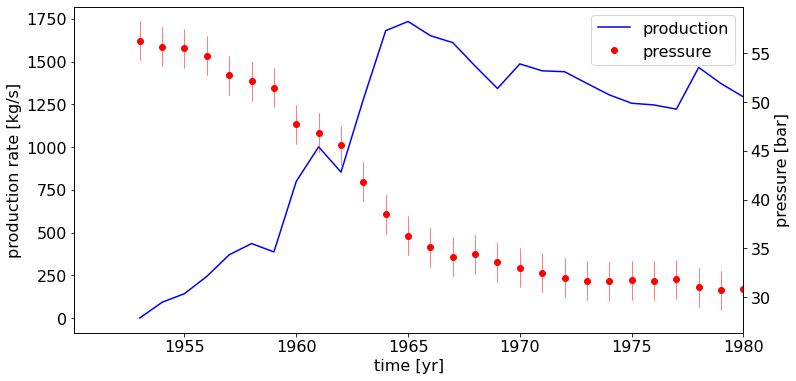

In [19]:
wairakei_data()

In [20]:
lpm_demo()

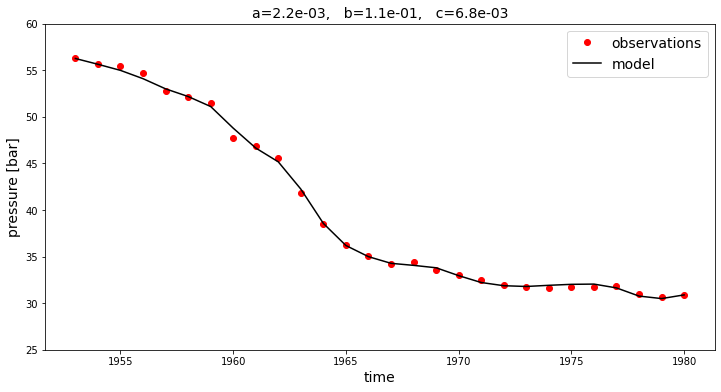

In [21]:
lpm_model()

In [ ]:
lpm_models()

In [ ]:
lpm_posterior()

In [ ]:
sa = 1.1e-4
sb = 5.5e-3
sc = 1.7e-3
lpm_prediction(sa,sb,sc)

In [22]:
lpm_structural()